<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/chatGPTMIDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

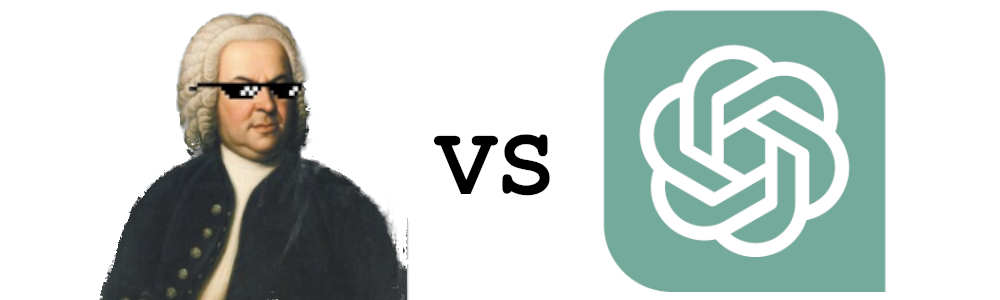
---

### Installation von notwendigen Paketen und Funktionsdefinitionen (bitte ausführen)

In [ ]:
%%capture
# installing some non-standard python packages
!pip install mido
!pip install pypianoroll
!apt install fluidsynth
!pip install midi2audio
!pip install --upgrade music21

In [ ]:
%%capture
# some stuff needed to display scores inside a notebook
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb

In [ ]:
file_ID = "18_HRx9G7-IKlEBDguJam7EIfv0WvU67l"
filename = 'default_sound_font.sf2'
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id={file_ID}' -O {filename}

In [ ]:
# import ting some libraries
import music21
us = music21.environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'
import glob
import mido
from mido import Message, MidiFile, MidiTrack
from IPython.display import Audio, clear_output,display
from midi2audio import FluidSynth
import pypianoroll
from matplotlib import pyplot as plt
from random import choice
import numpy as np
import pretty_midi

In [ ]:
def play_midi(midi_file):
    FluidSynth().midi_to_audio(midi_file, 'output_0.wav')
    display(Audio(filename = 'output_0.wav'))

In [ ]:
def display_midi(midi_file):
    midi = music21.converter.parse(midi_file)
    midi.show()

In [ ]:
def trim_midi(input_file,output_file,bars = 4,how = 'random'):
    midi_data = pretty_midi.PrettyMIDI(bach_file)
    numerator = midi_data.time_signature_changes[0].numerator
    denominator = midi_data.time_signature_changes[0].denominator
    pr = pypianoroll.read(input_file)
    factor = denominator/pr.resolution/numerator/4
    total_bars = int(np.ceil(pr.get_length()*factor))
    if how == 'start':
        pr = pr.trim(start=0,end = int(bars/factor))
    elif how == 'random':
        start = np.random.randint(0,total_bars-bars)
        pr =  pr.trim(start = start,end =  int(start+bars/factor))
    pm = pr.to_pretty_midi()
    time_signature = pretty_midi.TimeSignature(numerator=numerator, denominator=denominator,time = 0)
    pm.time_signature_changes.append(time_signature)
    pm.write(output_file)


# Was kann **chatGPT**?
Zu Beginn beschäftigen wir uns ein Wenig mit chatGPT. Obwohl es ein reines Sprachmodel ist, *versteht* es doch mehr von Musik als manch einer erwartet hätte. An einem der letzten Termine haben Sie bereits exploriert, was chatGPT mit der ABC-Notation anstellen kann. Heute widmen wir uns einem reichhaltigeren Format: dem [Midi](https://de.wikipedia.org/wiki/MIDI)-Protokoll.

Midi ist sowohl ein Kommunikationsprotokoll mit dem elektronische Musikgeräte kommunizieren können als auch eine Art Notenschrift für Computer, die als binäre (also von Menschen nicht lesbaren) Dateien gespeichert wird.


Midi-*Events* oder *Messages* können viele verschiedene Aspekte von musikalischer Performance kodieren. Die Spezifikation der Protokolls fÜllt ganze [Bände](https://www.midi.org/specifications). Für uns ist heute nur die Erzeugung von einfachen Tönen interessant. Ein solches Event sieht ungefähr so aus:


```
note_on channel=0 note=60 velocity=64 time=0
```

Hier soll Note nummer 60 zum Zeitpunkt 0 aud Kanal 0 mit Lautsärke 64 gepielt werden. Die Töne werden chromatisch als Zahl zwischen 0 und 127 angegeben, wobei 60 das mittlere C ist (C4). Die lautstärke variiert zwischen 0 (aus) und 127 (maximal laut). Mit Hilfe der Kanal-Zahl kann mann verschiedene Stimmen definieren.

Um mit chatGPT kommunizieren zu können, wäre es gut, eine einfachere Notation zu definieren. Wir ignorieren die Lautstärke und wollen uns auch nicht mit dem absoluten Timing auseinandersetzen.  Uns würde also eine liste von Ton-Dauer Paaren genügen, um eine Melodie zu definieren.

Ich habe im Vorfeld chatGPT gebeten, eine Funktion zu schreiben, die aus solch einer Liste eine Mididatei erzeugt, die wir dann abspielen und Darstellen können. Nach längerem Hin-und-Her kam die folgende Funktion dabei heraus:








In [ ]:
# this function was created with the aid of chatGPT. It takes as dictionary
# of lists of tuples with note names and durations like this:
# {"Track1": [(60, 1), (64, 0.5), (67, 0.5), (72, 2)],
#  "Track2": [(62, 0.5), (65, 1), (69, 0.5), (74, 2)]}
# the note names correspond to the midi indixes (0-127) and the
# durations are specified as multiples of quarter notes.

def bpm_to_tempo(bpm):
    return int(60 * 1e6 / bpm)  # Convert BPM to microseconds per beat

def create_midi(tracks, output_file,bpm=120, ticks_per_beat=480,time_signature = (4,4)):
    # Create a new MIDI file
    midi = MidiFile(ticks_per_beat=ticks_per_beat)

    # Set the tempo
    tempo = bpm_to_tempo(bpm)

    # Create a meta track for tempo (and potentially other meta information)
    meta_track = MidiTrack()
    midi.tracks.append(meta_track)

    # Add the set_tempo MetaMessage to the meta track
    meta_track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))


    # Iterate over each track in the input dictionary
    for track_name, note_durations in tracks.items():
        # Create a new track and add it to the MIDI file
        track = MidiTrack()
        midi.tracks.append(track)

        # Add a track name MetaMessage
        track.append(mido.MetaMessage('track_name', name=track_name, time=0))

        # Add the time_signature MetaMessage to the meta track
        numerator, denominator = time_signature
        meta_track.append(mido.MetaMessage('time_signature', numerator=numerator,
                                           denominator=denominator, clocks_per_click=24,
                                           notated_32nd_notes_per_beat=8, time=0))

        # Initialize the last event time
        last_event_ticks = 0

        # Iterate through the list of (note, duration) tuples for this track
        for note, duration in note_durations:
            note_ticks = int(ticks_per_beat * duration)

            if note is not None:
                # Add a note
                track.append(Message('note_on', note=note, velocity=64, time=last_event_ticks))
                track.append(Message('note_off', note=note, velocity=64, time=note_ticks))
                last_event_ticks = 0  # Reset the last event time for the next note
            else:  # Rest between notes
                last_event_ticks += note_ticks
    # save the Midi file
    midi.save(output_file)

# Example usage:
# create_midi({"Track1": [(60, 1), (64, 0.5), (67, 0.5), (72, 2)],
#              "Track2": [(62, 0.5), (65, 1), (69, 0.5), (74, 2)]}, bpm=120)



Wir können nun also ein *dictionary* erstellen, das mehrere Listen von Tonfolgen enthalten kann, die dann gleichzeitig abgespielt werden können. Die Dauer der Töne wird in vielfachen von Viertelnoten angegeben und der Wert `None` bedeutet eine Pause.

### Aufgabe:
Füllen Sie die Liste in der folgenden Zelle, um eine einfache Melodie zu erzeugen. Führen sie die beiden nächsten Zellen aus, um die Melodie darzustellen und abzuspielen.

Die folgende Darstellung wird dabei hilfreich sein:
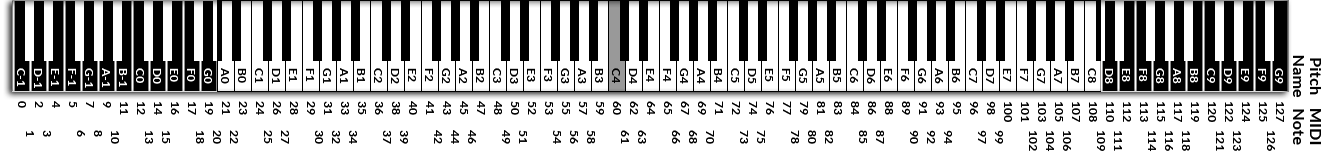

In [ ]:
# definieren Sie eine Melodie
melodie = {'stimme_1':[(60,1)]}

In [ ]:
# Erzeugung einer Mididatei
create_midi(melodie,'melodie.midi',time_signature = (3,4))
display_midi('melodie.midi')
play_midi('melodie.midi')

## **chatGPT** *komponiert*
Nun lassen Sie uns versuchen, chatGPT dazu zu bringen, eine Melodie in dieser Form zu erzeugen.
Zunächst müssen wir chatGPT unser Format erklären.
### Aufgabe
Öffnen Sie einen neuen chatGPT-chat und fügen Sie die folgende Erklärung ein:

*You are a composer. You communicate music in the form of a python dictionary. Each key in the dictionary corresponds to a voice in the musical piece. The corresponding items in the dictionary are lists of tuples where each tuple represents a note described by a pitch number and a duration. the pitch number between 0-127 corresponds to the midi protocol where 60 represents middle C. The duration is encoded as a fraction or multiple of a quarter note. Rests are represented by the note value None.*

Um zu testen, ob Sie verstanden wurden, bitten Sie chatGPT nun eine einfache Melodie zu komponieren und fügen das Ergebnis in die nächste Zelle ein.

In [ ]:
melodie = {}

In [ ]:
# Erzeugung einer Mididatei
create_midi(melodie,'melodie.midi')
display_midi('melodie.midi')
play_midi('melodie.midi')

Wenn Sie Glück hatten, hat chatGPT Ihnen eine syntaktisch korrekte Antwort gegeben. Vermutlich lässt die Melodie aber noch Wünsche offen.

### Aufgabe
Versuchen Sie durch genauere Beschreibung der gewünschten Melodie, ein besseres Ergebnis zu erzielen. Je mehr input Sie chatGPT geben, desto mehr Struktur wird es erzeugen. Machen Sie konstruktive Vorschläge und iterieren Sie, bis Sie mit dem Ergebnis zufrieden sind.

In [ ]:
melodie = {}

In [ ]:
# Erzeugung einer Mididatei
create_midi(melodie,'melodie.midi')
display_midi('melodie.midi')
play_midi('melodie.midi')

### Aufgabe
Prompten Sie nun eine zweite Stimme. Auch hier ist wieder geduldiges Erklären und eine Reihe von Anläufen gefragt.

In [ ]:
melodie =  {}



In [ ]:
# Erzeugung einer Mididatei
create_midi(melodie,'melodie.midi')
display_midi('melodie.midi')
play_midi('melodie.midi')

## Lernen vom **Meister**
So weit, so gut. Kommen wir nun zum oben angekündigten Duell. Was passiert, wenn wir chatGPT mit *echter* Musik füttern? Hierzu laden wir zunächst einen Datensatz von Midifiles mit Bachchorälen herunter.

In [ ]:
!git clone https://github.com/jamesrobertlloyd/infinite-bach.git

In [ ]:
midi_files = glob.glob('infinite-bach/**/*.mid',recursive = True)
print(len(mid_files))

Wir haben also 499 Bachchoräle heruntergeladen. Jetzt brauchen wir eine Funktion, die Mididateien in unser vereinfachtes Notenformat umwandelt. Diese Funktion ist wieder mit Hilfe von chatGPT entstanden:

In [ ]:
def read_midi(filename):
    # Load the MIDI file
    midi = mido.MidiFile(filename)

    # Prepare the output dictionary
    tracks = {}

    # Iterate over each track in the MIDI file
    for i, track in enumerate(midi.tracks):
        # Initialize the list of (note, duration) tuples for this track
        note_durations = []

        # Initialize the time
        last_msg_ticks = 0
        note_on_ticks = None
        note = None

        # Iterate over each message in the track
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                # If a previous note was playing, calculate its duration and add to the list
                if note is not None:
                    duration = (last_msg_ticks - note_on_ticks) / midi.ticks_per_beat
                    note_durations.append((note, duration))

                # Start a new note
                note = msg.note
                note_on_ticks = last_msg_ticks

            elif msg.type in ('note_off', 'note_on') and note is not None:
                # End the current note
                duration = (last_msg_ticks + msg.time - note_on_ticks) / midi.ticks_per_beat
                note_durations.append((note, duration))
                note = None

            last_msg_ticks += msg.time

        # If a note was playing at the end of the track, calculate its duration and add to the list
        if note is not None:
            duration = (last_msg_ticks - note_on_ticks) / midi.ticks_per_beat
            note_durations.append((note, duration))

        # Find the track name
        track_name = f"Track {i+1}"
        for msg in track:
            if msg.type == 'track_name':
                track_name = msg.name
                break

        # Add this track to the output dictionary
        tracks[track_name] = note_durations

    if 'Track 1' in tracks.keys() and len(tracks['Track 1'])==0:
        del tracks['Track 1']
    return tracks

# Example usage:
# print(read_midi('music.midi'))


Um zu sehen, ob es funktioniert hat, wählen wir eine zufällige Datei aus und stellen sie dar.

In [ ]:
# auswahl einer zufälligen Datei
bach_file = choice(midi_files)

In [ ]:
# Darstellung als Noten
display_midi(bach_file)
play_midi(bach_file)

In [ ]:
music = read_midi(bach_file)
print(music)

Da wir chatGPT nicht überfordern wollen, schneiden wir die Choräle in kleinere häppchen. Diese können wir mit der Funktion `trim_midi` erreichen.

In [ ]:
# cut 4 bars from the beginning
trim_midi(bach_file,'trimmed_bach_file.mid', bars =4, how = 'start')
display_midi('trimmed_bach_file.mid')

In unserer Notation sehen die ersten vier Takte so aus:

In [ ]:
music =  read_midi('trimmed_bach_file.mid')
print(music)

### Aufgabe
Kopieren Sie diese vier Takte, und bitten Sie chatGPT, eine Fortsetzung zu komponieren. Die Fortsetzung können Sie wieder unten einfügen, um sie zu inspzieren.


In [ ]:
fortsetzung = {}

In [ ]:
create_midi(fortsetzung,'fortsetzung.midi')
display_midi('fortsetzung.midi')
play_midi('fortsetzung.midi')

Wenn wir glÜck haben, wurde die Aufgabe formell erfÜllt. Die Komposition reicht aber vermutlich noch nicht an das heran, was wir von Bach gewohnt sind.
Können wir chatCPT *trainieren*?
## Aufgabe
Die folgenden Zellen ermöglichen Ihnen, zufällige Sequenzen aus den 499 Chorälen zu erzeugen. Füttern Sie chatGPT mit Beispielen von gelungeneren Kompositionen. Probieren Sie nach einigen versuchen aus, ob das *Weiterkomponieren* jetzt besser funktionert.

In [ ]:
takte = 8 # die Länge der Schnipsel in Takten
random_file = choice(midi_files)
trim_midi(random_file,'random_snippet.mid',bars = takte,how =  'random')
music = read_midi('random_snippet.mid')
print(music)

Wenn Sie einige Trainingsbeispiele eingegeben haben, fordern Sie chatGPT erneut auf, die Sequenz von weiter oben *fertigzukomponieren*. Fügen Sie das Ergebnis unten ein. Hat sich die Qualität verbessert?

In [ ]:
music = {}



In [ ]:
create_midi(music,'fortsetzung_2.midi')
display_midi('fortsetzung_2.midi')
play_midi('fortsetzung_2.midi')

Hat sich die Qualität des Ouputs verändert? Würden Sie sagen, dass chatGPT in dieser Session etwas *gelernt* hat?

### Aufgabe
Nach diesem intensiven Kompositionsunterricht, bitten Sie chatGPT, eine eigenständige Komposition unter berücksichtigung aller bisherigen Inputs zu erstellen.

In [ ]:
komposition = {}


In [ ]:
create_midi(komposition,'komposition.midi')
display_midi('komposition.midi')
play_midi('komposition.midi')

Wir haben einen klaren Sieger:

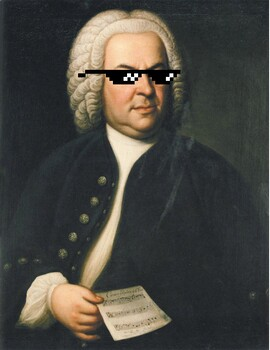